In [1]:
import numpy as np
import pandas as pd

import itertools
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

In [2]:
class Perceptron(object):
    def __init__(self, learning_rate, max_iter = 1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
    
    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), np.array(X)])
        return np.array([self._predict_one(v) for v in X])
    
    def _predict_one(self, x):
        return int(np.dot(self.weights.T, x) >= 0)
    
    def fit(self, X, y, verbose = False):
        X = np.hstack([np.ones((X.shape[0], 1)), np.array(X)])
        y = np.array(y)
        
        n = X.shape[0]
        
        if self.max_iter < n:
            self.max_iter = n
        
        self.weights = np.random.normal(size=X.shape[1])
        
        best_weights = self.weights.copy()
        best_score = 0.
        
        for i in range(self.max_iter):
            idx = i % n
            pred = self._predict_one(X[idx])
            if pred != y[idx]:
                if pred == 0:
                    self.weights += self.learning_rate*X[idx]
                else:
                    self.weights -= self.learning_rate*X[idx]
                    
            cur_score = accuracy_score(y, [self._predict_one(v) for v in X])
            
            if verbose and i % 100 == 0:
                print 'iteration: {}, accuracy:{}'.format(i, cur_score)
                
            if cur_score > best_score:
                best_score = cur_score
                best_weights = self.weights.copy()
        
        if verbose:
            print 'best score: {}'.format(best_score)
            print 'best weights: {}'.format(best_weights)
            
        self.weights = best_weights

In [3]:
data = pd.read_csv('data/blobs2.csv')

In [4]:
X = data.drop(['label'], axis=1)
y = data['label']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75)

In [6]:
model = Perceptron(learning_rate=0.5)
model.fit(X_train, y_train, verbose = True)

iteration: 0, accuracy:0.501333333333
iteration: 100, accuracy:0.952
iteration: 200, accuracy:0.912
iteration: 300, accuracy:0.904
iteration: 400, accuracy:0.956
iteration: 500, accuracy:0.956
iteration: 600, accuracy:0.966666666667
iteration: 700, accuracy:0.957333333333
iteration: 800, accuracy:0.972
iteration: 900, accuracy:0.978666666667
best score: 0.978666666667
best weights: [ 6.1127419   1.58980214 -3.27969804]


In [7]:
preds = model.predict(X_test)
print accuracy_score(y_test, preds)

0.968


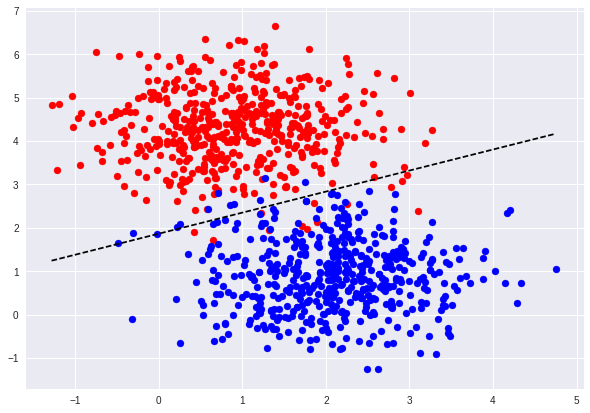

In [8]:
plt.figure(figsize=(10, 7))
plt.scatter(data[data['label'] == 0]['x'], data[data['label'] == 0]['y'], color='red')
plt.scatter(data[data['label'] == 1]['x'], data[data['label'] == 1]['y'], color='blue')
a, b = -model.weights[1]/model.weights[2], -model.weights[0]/model.weights[2]
l = np.linspace(np.min(data['x']), np.max(data['x']))
plt.plot(l, a*l+b, 'k--')

In [9]:
def plot_polynomial(X, k):
    poly = PolynomialFeatures(degree=k)
    X = poly.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75)
    model = Perceptron(learning_rate=0.5)
    model.fit(X_train, y_train, verbose = False)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print 'degree: {}, accuracy: {}'.format(k, acc)

In [10]:
plot_polynomial(X, 3)

degree: 3, accuracy: 0.976
